In [2]:
import pandas as pd

In [3]:
df=pd.read_csv(
"/Users/linqianpeng/Documents/projects/skincare-ingredient-analysis/data/skincare_products_clean.csv")

In [4]:
df.head()

,product_name,product_url,product_type,clean_ingreds,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"['capric triglyceride', 'cetyl alcohol', 'prop...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"['homosalate', 'glycerin', 'octocrylene', 'eth...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"['sodium hyaluronate', 'sodium hyaluronate', '...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"['ammonium lactate', 'c12-15', 'glycerin', 'pr...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"['glycerin', 'cetearyl alcohol', 'capric trigl...",£16.00


In [5]:
df.product_type.unique()

array(['Moisturiser', 'Serum', 'Oil', 'Mist', 'Balm', 'Mask', 'Peel',
       'Eye Care', 'Cleanser', 'Toner', 'Exfoliator', 'Bath Salts',
       'Body Wash', 'Bath Oil'], dtype=object)

In [6]:
import ast

df['ingred_list'] = df['clean_ingreds'].apply(ast.literal_eval)


In [11]:
df.iloc[0].ingred_list

['capric triglyceride',
 'cetyl alcohol',
 'propanediol',
 'stearyl alcohol',
 'glycerin',
 'sodium hyaluronate',
 'arganine',
 'aspartic acid',
 'glycine',
 'alanine',
 'serine',
 'valine',
 'isoleucine',
 'proline',
 'threonine',
 'histidine',
 'phenylalanine',
 'glucose',
 'maltose',
 'fructose',
 'trehalose',
 'sodium pca',
 'pca',
 'sodium lactate',
 'urea',
 'allantoin',
 'linoleic acid',
 'oleic acid',
 'phytosteryl canola glycerides',
 'palmitic acid',
 'stearic acid',
 'lecithin',
 'triolein',
 'tocopherol',
 'carbomer',
 'isoceteth-20',
 'polysorbate 60',
 'sodium chloride',
 'citric acid',
 'trisodium ethylenediamine disuccinate',
 'pentylene glycol',
 'triethanolamine',
 'sodium hydroxide',
 'phenoxyethanol',
 'chlorphenesin']

In [12]:
import pandas as pd
from collections import Counter

# N: How many top ingredients you want
N = 10

# To store results
results = []

# Loop over each product_type group
for product_type, group in df.groupby('product_type'):
    total_products = len(group)
    
    # Flatten all ingredients for this group
    all_ingredients = sum(group['ingred_list'], [])
    
    # Count ingredient frequency
    counts = Counter(all_ingredients)
    
    # Get top N ingredients
    top_ingredients = counts.most_common(N)
    
    # Calculate percentage
    for ingred, count in top_ingredients:
        percentage = count / total_products * 100  # percentage
        results.append({
            'product_type': product_type,
            'ingredient': ingred,
            'count': count,
            'percentage': round(percentage, 2)
        })

# Create a result dataframe
top_ingredients_df = pd.DataFrame(results)

# Sort nicely
top_ingredients_df = top_ingredients_df.sort_values(['product_type', 'percentage'], ascending=[True, False])


In [13]:
top_ingredients_df

,product_type,ingredient,count,percentage
0,Balm,tocopherol,40,65.57
1,Balm,butyrospermum parkii,31,50.82
2,Balm,cera alba,29,47.54
3,Balm,helianthus annuus seed oil,29,47.54
4,Balm,linalool,28,45.90
...,...,...,...,...
135,Toner,butylene glycol,26,35.62
136,Toner,castor oil,26,35.62
137,Toner,potassium sorbate,22,30.14
138,Toner,sodium hydroxide,21,28.77


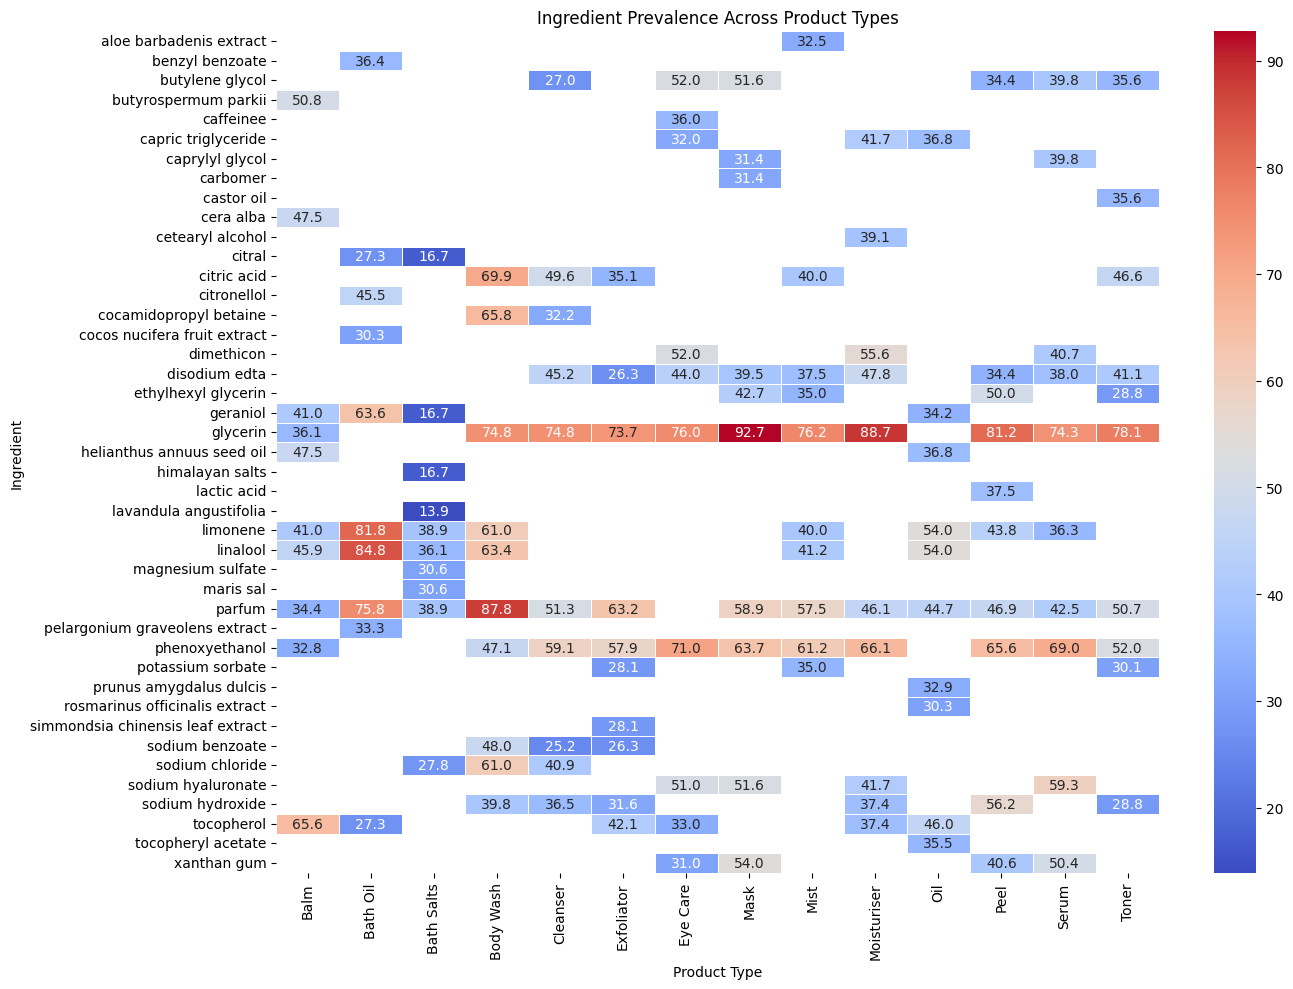

In [16]:
heatmap_data = top_ingredients_df.pivot(index='ingredient', columns='product_type', values='percentage')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5, annot=True, fmt=".1f")
plt.title("Ingredient Prevalence Across Product Types")
plt.xlabel("Product Type")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()


In [27]:
# Explode dataframe so each row is (product, ingredient)
df_exploded = df[['product_type', 'ingred_list']].explode('ingred_list')


In [28]:
# Total number of products
total_products = df.shape[0]

# Ingredient appearance counts (number of products it appears in)
ingredient_counts = df_exploded.groupby('ingred_list')['product_type'].nunique()  # Number of unique products

# Appearance percentage
ingredient_freq = df_exploded.groupby('ingred_list')['product_type'].count() / total_products * 100
ingredient_freq = ingredient_freq.rename('frequency_pct')


In [29]:
import numpy as np

# Create a crosstab: ingredient vs product type counts
crosstab = pd.crosstab(df_exploded['ingred_list'], df_exploded['product_type'])

# Normalize by row to get p(i) distribution
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

# Calculate entropy for each ingredient
entropy = -(crosstab_norm * np.log(crosstab_norm + 1e-9)).sum(axis=1)  # Small epsilon to avoid log(0)
entropy = entropy.rename('entropy')


In [30]:
ingredient_stats = pd.concat([ingredient_freq, entropy], axis=1).reset_index()


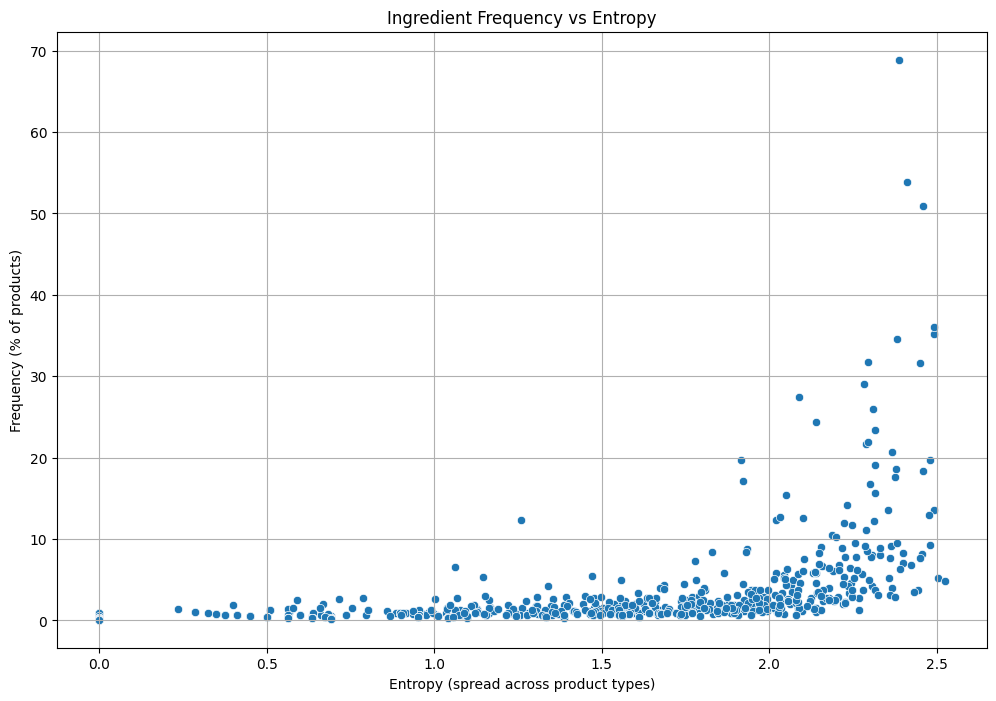

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='entropy',
    y='frequency_pct',
    data=ingredient_stats
)
plt.xlabel('Entropy (spread across product types)')
plt.ylabel('Frequency (% of products)')
plt.title('Ingredient Frequency vs Entropy')
plt.grid(True)
plt.show()


In [22]:
# Define N
N = 10

# Filter top N per product_type
topN_df = (top_ingredients_df.groupby('product_type')
           .head(N))

# Get all unique ingredients across all product types' Top-N
top_ingredients_all = set(topN_df['ingredient'])
print(f"Number of unique top ingredients: {len(top_ingredients_all)}")


Number of unique top ingredients: 43


In [23]:
# Keep only ingredients that are in top_ingredients_all
df['ingred_list_top'] = df['ingred_list'].apply(lambda ingreds: [i for i in ingreds if i in top_ingredients_all])


In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=list(top_ingredients_all))  # Fix the order
ingred_matrix = mlb.fit_transform(df['ingred_list_top'])

# Now, ingred_matrix shape: (num_products, num_top_ingredients)
print(ingred_matrix.shape)


(1138, 43)


In [25]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# Fit and transform
tsne_results = tsne.fit_transform(ingred_matrix)

# Add back to DataFrame
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]


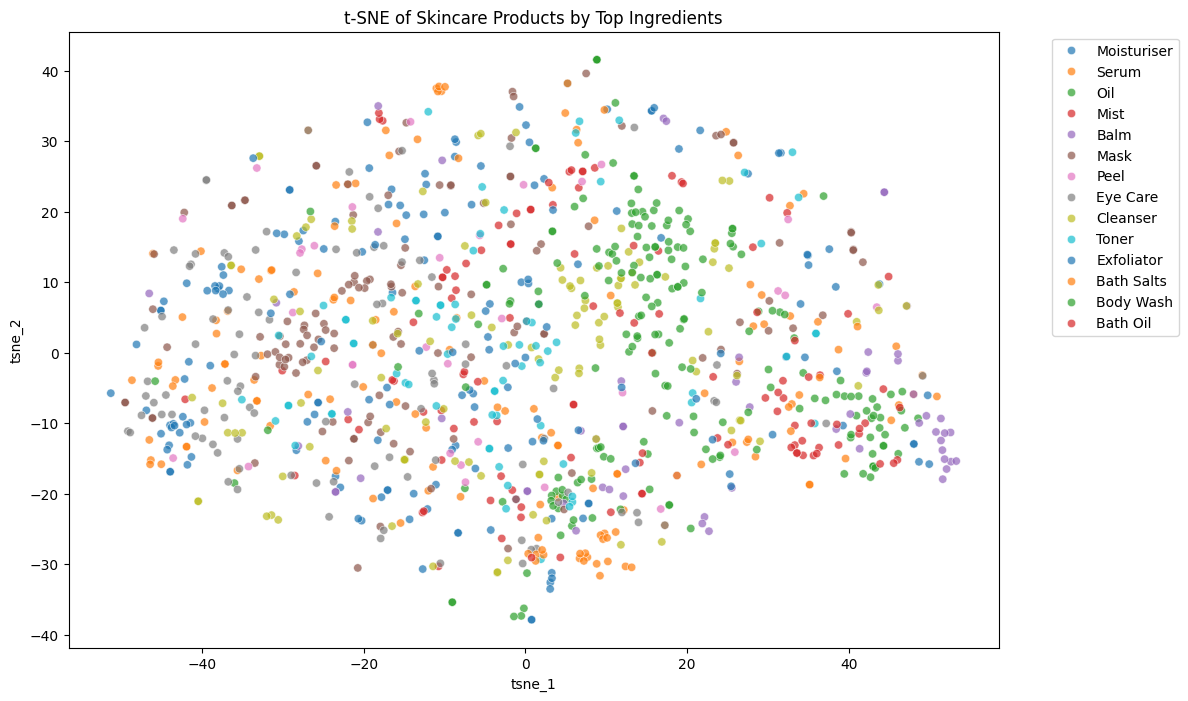

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='product_type',
    palette='tab10',
    data=df,
    alpha=0.7
)
plt.title('t-SNE of Skincare Products by Top Ingredients')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


In [ ]:
## 
function 
## similarity : dot product : 
## 1. main ingredients : wtop ingredients per product type : functional purposes?
## 2. overlap between product type? what is closer to each other ? (maybe a tsne with color of each product)
## 3. price correlation to ingredients? are there pattern
## 3. feature: upload 3 products of different price point: see differences on ingredients? are those ingredients
## related to higher price? if not its a branding thing 

In [55]:
## hi im first time getting into skin care and theres overwhelm of products and process. im looking into kroean skin care routine and there are 12 steps. are all these differnet moisturizing (variation of moisturizers _ all that differnet?) are all 12 steps actually helpful or just marketing scams to buy more product? ifi. group everything int omain function how many steps are there / should be there really for skin care? 
## OVERLAPS!
## how are prices varies: how are there different prices point of the same thing ?
## several analysis
## print your skin care and see what kind of 

In [56]:
# get all ingredients how many ingredients are there? 


In [57]:
import ast

df['ingred_list'] = df['clean_ingreds'].apply(ast.literal_eval)


In [58]:
df = df.explode('ingred_list')

In [59]:
df.ingred_list.nunique()

2572

In [60]:
ingredient_count=df.groupby(['product_type','ingred_list'])['product_name'].nunique().reset_index()

In [61]:
ingredient_count.sort_values(by=['product_name'],ascending=False)

,product_type,ingred_list,product_name
3706,Mask,glycerin,115
1107,Body Wash,parfum,108
4983,Moisturiser,glycerin,102
993,Body Wash,glycerin,92
1547,Cleanser,glycerin,86
...,...,...,...
4675,Mist,trisodium ethylenediamine disuccinate,1
4676,Mist,tromethamine,1
4677,Mist,tropolone,1
4678,Mist,tyrosine,1


In [74]:
ingredient_count[ingredient_count.ingred_list.str.contains('Retinol')]

,product_type,ingred_list,product_name


In [67]:
ingredient_count[ingredient_count.product_name>5].ingred_list.nunique()

349

In [68]:
ingredient_count[ingredient_count.product_name>10].ingred_list.nunique()

173

In [40]:
ingredient_count.product_name.nunique()

73

<Axes: >

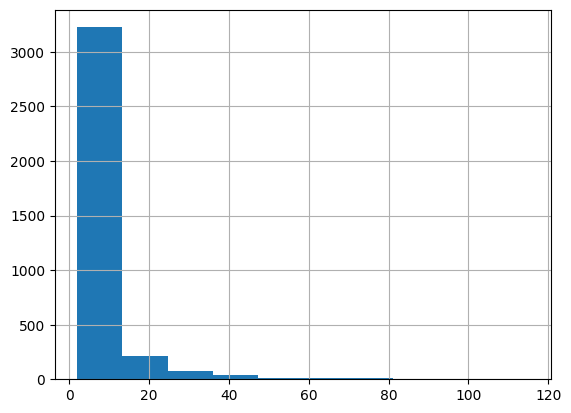

In [62]:
ingredient_count[ingredient_count.product_name>1].product_name.hist()